# Self-RAG

이 튜토리얼에서는 **Self-RAG**라는 Retrieval Augmented Generation(RAG) 전략을 소개하고, 이를 [LangGraph](https://langchain-ai.github.io/langgraph/)를 활용하여 구현하는 방법을 단계별로 설명합니다. 

Self-RAG는 검색된 문서와 생성된 응답에 대한 자기 반성(self-reflection) 및 자기 평가(self-evaluation)를 포함한 RAG 전략으로, RAG 기반 시스템의 성능 향상에 기여할 수 있습니다.

![](./assets/langgraph-self-rag.png)

---

**Self-RAG란 무엇인가?**

**Self-RAG**는 검색된 문서와 생성된 응답 모두에 대해 점검하고 검증하는 추가 단계를 포함하는 RAG 전략입니다.   
전통적인 RAG에서는 검색된 정보를 기반으로 LLM이 답변을 생성하는 것이 주된 과정이었다면, Self-RAG에서는 **자체 평가**를 통해 다음과 같은 사항을 검증합니다.

1. 검색할 필요성 판단: 현재 질문에 대해 추가 검색이 필요한지 여부를 판단합니다.
2. 검색 결과 관련성 평가: 검색된 문서 조각(청크)이 질문 해결에 도움이 되는지 확인합니다.
3. 응답 사실성 검증: 생성된 답변이 제공된 문서 청크에 의해 충분히 뒷받침되는지 평가합니다.
4. 응답 품질 평가: 생성된 답변이 실제로 질문을 잘 해결하는지 측정합니다.

이 과정을 통해 단순히 검색하고 답변을 생성하는 단계를 넘어, 생성된 응답의 품질과 사실성을 스스로 모니터링하고 향상시킬 수 있습니다.

[Self-RAG 논문 바로가기](https://arxiv.org/abs/2310.11511)

---

**Self-RAG 주요 개념 정리**

논문에서는 Self-RAG를 통해 다음과 같은 결정 과정을 제안합니다.

1. **Retriever 사용 여부 결정**  
   - 입력: `x (question)` 또는 `(x (question), y (generation))`  
   - 출력: `yes, no, continue`  
   이 단계는 추가 검색을 진행할지, 검색 없이 그대로 진행할지, 혹은 더 기다려볼지 결정합니다.
   
2. **관련성 평가 (Retrieval Grader)**  
   - 입력: (`x (question)`, `d (chunk)`) for each `d` in `D`  
   - 출력: `relevant` 또는 `irrelevant`  
   검색된 문서 청크들이 실제로 질문에 답하는데 유용한 정보인지 판별합니다.
   
3. **사실성 검증 (Hallucination Grader)**  
   - 입력: `x (question)`, `d (chunk)`, `y (generation)` for each `d` in `D`  
   - 출력: `{fully supported, partially supported, no support}`  
   생성된 응답이 검색 결과에 근거한 사실을 반영하는지, 혹은 환각(Hallucination)이 발생했는지 판단합니다.
   
4. **정답 품질 평가 (Answer Grader)**  
   - 입력: `x (question)`, `y (generation)`  
   - 출력: `{5, 4, 3, 2, 1}`  
   생성된 응답이 질문을 어느 정도 해결하는지 점수화하여 평가합니다.

---

**이 튜토리얼에서 다룰 내용**

이 튜토리얼은 LangGraph를 활용하여 Self-RAG 전략의 일부 아이디어를 구현하는 과정을 다룹니다.  
다음과 같은 단계를 통해 Self-RAG 전략을 구축하고 실행하는 방법을 익히게 됩니다.

- **Retriever**: 문서를 검색
- **Retrieval Grader**: 검색된 문서의 관련성 평가
- **Generate**: 질문에 대한 답변 생성
- **Hallucination Grader**: 생성된 답변의 사실성(환각 여부) 검증
- **Answer Grader**: 답변의 질문에 대한 관련성 평가
- **Question Re-writer**: 쿼리 재작성
- **그래프 생성 및 실행**: 정의한 노드로 그래프를 빌드하고 실행

---

**참고**

- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)  
- [Self-RAG 논문](https://arxiv.org/abs/2310.11511)  

## 환경설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다.
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-RAG


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retriever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.

**실습에 활용한 문서**

소프트웨어정책연구소(SPRi) - 2023년 12월호

- 저자: 유재흥(AI정책연구실 책임연구원), 이지수(AI정책연구실 위촉연구원)
- 링크: https://spri.kr/posts/view/23669
- 파일명: `SPRI_AI_Brief_2023년12월호_F.pdf`

_실습을 위해 다운로드 받은 파일을 `data` 폴더로 복사해 주시기 바랍니다_

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

Cache configured for multi-PDF processing
Loading PDF: data/SPRI_AI_Brief_2023년12월호_F.pdf
Successfully loaded 23 pages from: data/SPRI_AI_Brief_2023년12월호_F.pdf

Loading Summary:
- Successfully loaded: 1 files
- Failed to load: 0 files
- Total documents loaded: 23
FAISS index saved to cache


## 문서 검색 평가기 (Retrieval Grader)

추후 retrieve 노드에서 문서에 대한 관련성 평가를 진행하기 위해 미리 정의합니다.


In [4]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 최신모델 이름 설정
MODEL_NAME = get_model_name(LLMs.GPT4o)


# 데이터 모델 정의: 검색된 문서의 관련성을 이진 점수로 평가하기 위한 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved documents."""

    # 문서가 질문에 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 LLM의 구조화된 출력 생성
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의: 검색된 문서가 사용자 질문에 관련이 있는지 평가하는 시스템 역할 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 검색 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader

`retrieval_grader` 를 실행하여 검색된 문서의 관련성 평가를 수행합니다.

In [5]:
# 질문 정의
question = "삼성전자가 개발한 생성형 AI 의 이름은?"

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서 중 두 번째 문서의 페이지 콘텐츠 추출
doc_txt = docs[1].page_content

# 검색 평가기 호출 및 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


## 답변 생성 체인

답변 생성 체인은 검색된 문서를 기반으로 답변을 생성하는 체인입니다.

우리가 알고 있는 일반적인 Naive RAG 체인 입니다.

In [6]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# LangChain Hub에서 프롬프트 가져오기
prompt = hub.pull("teddynote/rag-prompt")

# 기본 LLM 초기화, 모델 이름과 온도 설정
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()

# 체인 실행
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)


## 답변의 할루시네이션 여부를 평가

`groundedness_grader` 를 생성하고 생성된 답변과 `context` 를 기반하여 답변의 할루시네이션 평가를 진행합니다.


`yes` 인 경우 답변의 할루시네이션이 없을을 의미합니다. 반대로, `no` 인 경우 답변이 할루시네이션으라고 간주합니다.

In [7]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# 데이터 모델 정의: 생성된 답변이 사실에 기반하고 있는지 여부를 이진 점수로 평가하기 위한 데이터 모델
class Groundednesss(BaseModel):
    """A binary score indicating whether the generated answer is grounded in the facts."""

    # 답변이 사실에 기반하고 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 구조화된 출력과 함께 LLM 설정
structured_llm_grader = llm.with_structured_output(Groundednesss)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 채팅 프롬프트 템플릿 생성
groundedness_checking_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 답변의 할루시네이션 평가기 생성
groundedness_grader = groundedness_checking_prompt | structured_llm_grader

In [8]:
# 할루시네이션 평가기 호출(yes: 사실에 기반하고 있음, no: 사실에 기반하고 있지 않음)
groundedness_grader.invoke({"documents": format_docs(docs), "generation": generation})

Groundednesss(binary_score='yes')

## 답변의 관련성 평가

생성된 답변이 질문(question) 과의 관련성 있는 답변인지 여부를 평가합니다.

`yes` 인 경우는 관련성 있음. `no` 인 경우는 관련성 없음을 의미합니다.

In [9]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


class GradeAnswer(BaseModel):
    """A binary score indicating whether the question is addressed."""

    # 답변의 관련성 평가: 'yes' 또는 'no'로 표기(yes: 관련성 있음, no: 관련성 없음)
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# llm 에 GradeAnswer 바인딩
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 생성
answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 답변 평가기 생성
answer_grader = answer_grader_prompt | structured_llm_grader

In [10]:
# 답변 평가기 호출(yes: 질문을 해결함, no: 질문을 해결하지 않음)
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## 질문 재작성기(Question Rewriter)

사용자가 입력한 질문 재작성기를 생성합니다.

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 시스템 프롬프트 정의
# 입력 질문을 벡터스토어 검색에 최적화된 형태로 변환하는 시스템 역할 정의
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 시스템 메시지와 초기 질문을 포함한 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# 질문 재작성기 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [12]:
# 질문 재작성기 호출
question_rewriter.invoke({"question": question})

'삼성전자가 개발한 생성형 인공지능의 이름은 무엇인가요?'

## 상태 정의

상태(State)를 정의합니다.

- `question`: 사용자가 입력한 질문
- `generation`: 생성된 응답
- `documents`: 검색된 문서 목록

In [13]:
from typing import List
from typing_extensions import TypedDict, Annotated


# 그래프의 상태를 나타내는 클래스 정의
class GraphState(TypedDict):
    # 질문을 나타내는 문자열
    question: Annotated[str, "Question"]
    # LLM에 의해 생성된 응답을 나타내는 문자열
    generation: Annotated[str, "LLM Generation"]
    # 문서의 목록을 나타내는 문자열 리스트
    documents: Annotated[List[str], "Retrieved Documents"]

## 노드 정의

- `retrieve`: 문서 검색
- `grade_documents`: 문서 평가
- `generate`: 답변 생성
- `transform_query`: 질문 재작성


In [14]:
# 문서 검색
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성
def generate(state):
    print("==== [GENERATE] ====")
    question = state["question"]
    documents = state["documents"]

    # RAG 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 검색된 문서의 관련성 평가
def grade_documents(state):
    print("==== [GRADE DOCUMENTS] ====")
    question = state["question"]
    documents = state["documents"]

    # 각 문서 점수 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("==== GRADE: DOCUMENT RELEVANT ====")
            filtered_docs.append(d)
        else:
            print("==== GRADE: DOCUMENT NOT RELEVANT ====")
            continue
    return {"documents": filtered_docs}


# 질문 변환
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}

## 조건부 엣지 정의

`decide_to_generate` 함수는 검색된 문서의 관련성 평가 결과에 따라 답변 생성 여부를 결정합니다.

`grade_generation_v_documents_and_question` 함수는 생성된 답변의 문서 및 질문과의 관련성 평가 결과에 따라 답변 생성 여부를 결정합니다.

In [15]:
# 답변 생성 여부 결정
def decide_to_generate(state):
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성이 없는 경우
        # 새로운 쿼리 생성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


# 생성된 답변의 문서 및 질문과의 관련성 평가
def grade_generation_v_documents_and_question(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = groundedness_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 환각 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")
        # 질문 해결 여부 확인
        print("==== [GRADE GENERATION vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("==== [DECISION: GENERATION ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATION DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"

## 그래프 생성

이전에 작성한 노드와 엣지를 통해 그래프를 생성합니다.

In [16]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# 엣지 정의
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# 엣지 정의
workflow.add_edge("transform_query", "retrieve")

# 답변 생성 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "generate",
        "relevant": END,
        "not relevant": "transform_query",
    },
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

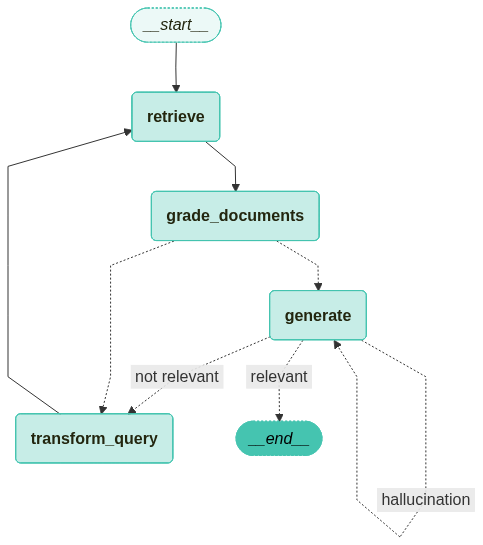

In [17]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

생성한 그래프를 실행합니다.

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 그래프 실행
invoke_graph(
    app, inputs, config, ["retrieve", "transform_query", "grade_documents", "generate"]
)

만약, 사용자의 질문에 대한 관련성 평가에서 지속적인 failure가 발생하는 경우, 다음과 같이 재귀상태로 빠질 수 있습니다.

In [ ]:
from langgraph.errors import GraphRecursionError

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "테디노트가 개발한 생성형 AI 의 이름은?",
}

try:
    # 그래프 실행
    stream_graph(
        app,
        inputs,
        config,
        ["retrieve", "transform_query", "grade_documents", "generate"],
    )
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")

이렇게 재귀상태에 빠지지 않도록 탈출을 위한 로직 수정(흐름의 수정)이 필요합니다.